# Variational Recurrent Auto-Encoders
_Otto Fabius & Joost R. van Amersfoort_

In [1]:
import model
import pretty_midi
import glob
import os
import numpy as np
import tensorflow as tf
from piano_roll_to_midi import PianoRollToMIDI
import matplotlib.pyplot as plt
%matplotlib inline

/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# function to convert model output to MIDI
def output_to_midi(x, out_file):
    x = np.squeeze(np.round(x), axis=0)
    temp = np.zeros((x.shape[0], 128))
    temp[:, 21:109] = x
    temp[temp==1] = 105

    mid = PianoRollToMIDI.convert(temp.T, fs=16, program=0)
    mid.write(out_file)

## Dataset preprocessing

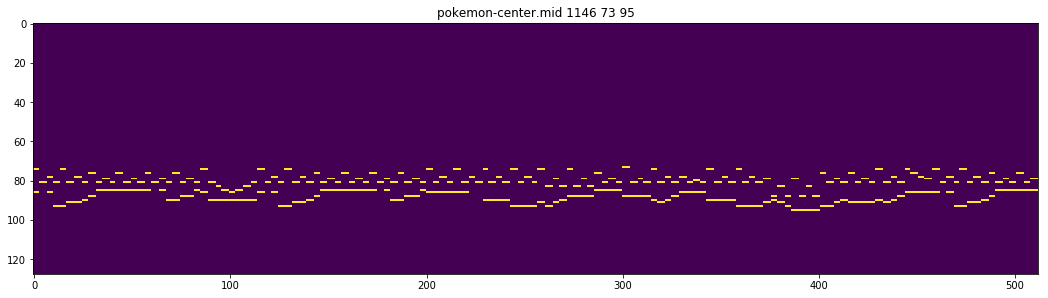

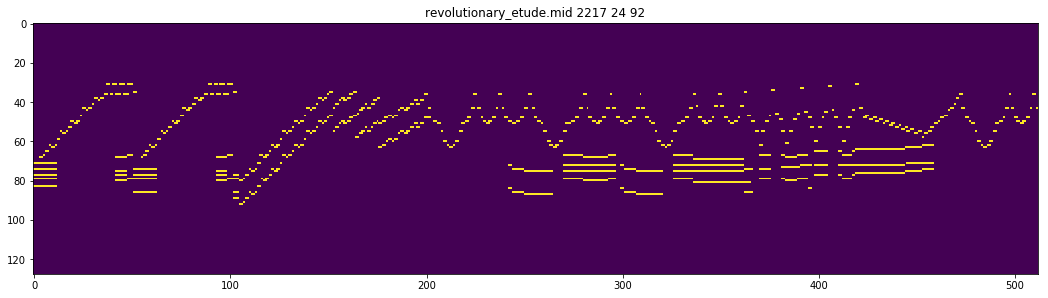

/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


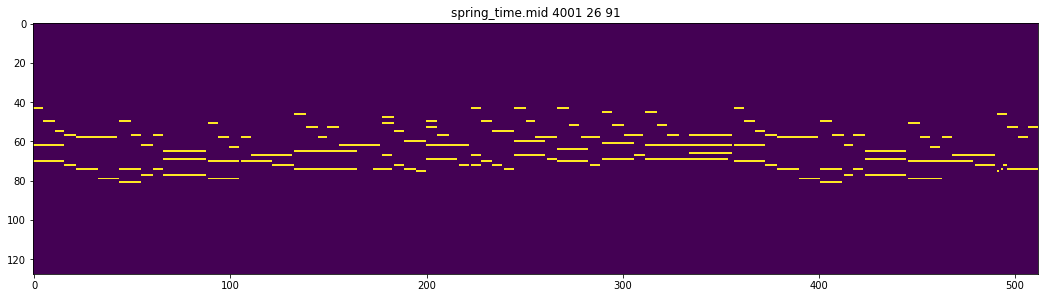

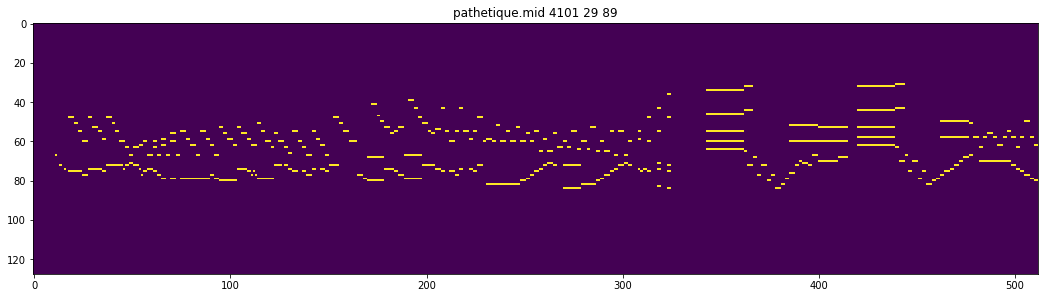

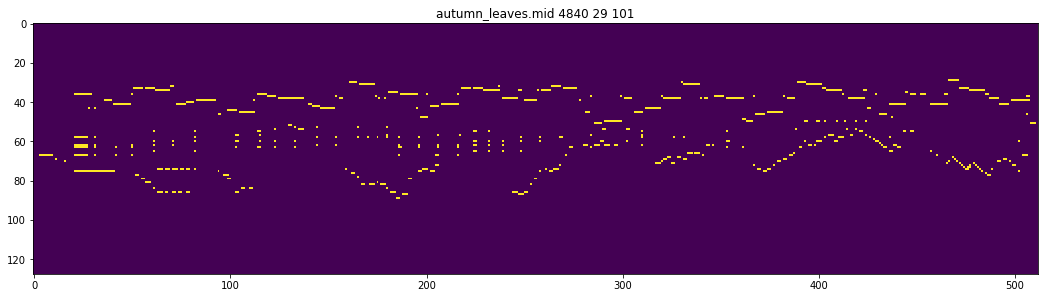

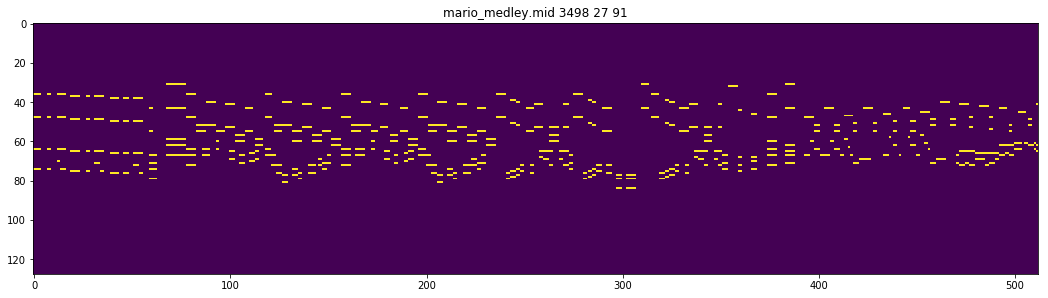

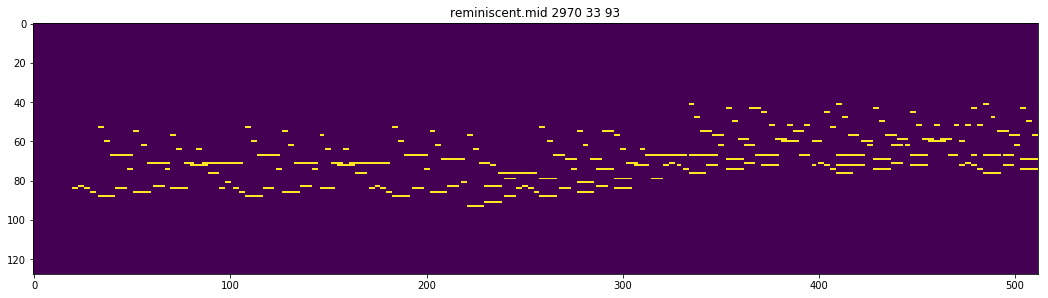

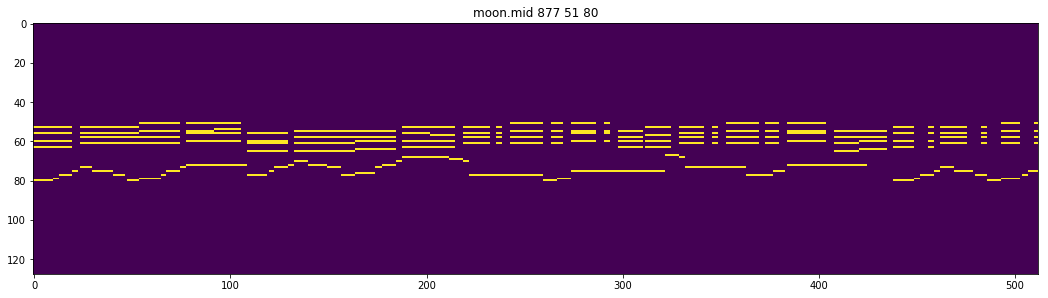

In [3]:
files = glob.glob("dataset/*")
piano_rolls = []
for file in files:
    mid = pretty_midi.PrettyMIDI(file)
    roll = mid.get_piano_roll(fs=16).astype(np.int32)
    roll[roll!=0] = 1
    piano_rolls.append(roll)
    
    bounds = np.nonzero(roll)[0]
    up, down = max(bounds), min(bounds)
    
    plt.figure(figsize=(18, 10))
    plt.title("{} {} {} {}".format(os.path.split(file)[-1], roll.shape[1], down, up))
    plt.imshow(roll[:, :512])
    plt.show()

## Experiment 1

Made some small changes to the original experiment to fit my dataset.  

|   Original     | This Experiment |
|----------------|-----------------|
| Sampled at 20Hz| Sampled at 16HZ |
| Keep first 520 | Keep first 800 | 
| Keep 49 pitches| Keep 88 pitches |
| 50 non overlapping time steps|  

Model parameters:
1. Adam optimizer $\beta _1$ = 0.05   $\beta_2$ = 0.001
1. Learning rate annealing (initial lr = 1e-3)
1. RNN dim = 500
1. Z dim = 2
1. epochs = 40000

In [4]:
X = []
for roll in piano_rolls:
    for i in range(0, 800, 50):
        temp = roll.T[i:i+50, 21:109]
        X.append(temp)
    
y = []
for i in range(8):
    y.append(np.ones((16,), dtype=np.int32)*i)
    
X = np.stack(X)
y = np.concatenate(y)

test = piano_rolls[0].T[-50:, 21:109]

print(X.shape)
print(y.shape)

(128, 50, 88)
(128,)


In [5]:
inputs = tf.placeholder(tf.float32, (None, 50, 88), name="X")
vrae = model.build_vrae(inputs, rnn_dim=500, z_dim=2)

global_step = tf.train.create_global_step()
lr = tf.train.exponential_decay(1e-3, global_step, 900, 0.965)
opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.05, beta2=0.001)
train_op = opt.minimize(vrae["total_loss"], global_step=global_step)

summaries = [tf.summary.scalar("lower_bound", vrae["latent_loss"]), 
             tf.summary.scalar("reconstruction_loss", vrae["recon_loss"]),
             tf.summary.scalar("loss", vrae["total_loss"]), 
             tf.summary.image("reconstructed", tf.expand_dims(vrae["x_out"]*255, axis=-1)),
             tf.summary.scalar("learning_rate", lr)]
summ_op = tf.summary.merge(summaries)

saver = tf.train.Saver(max_to_keep=20)
init = tf.global_variables_initializer()

500 5.326536178588867


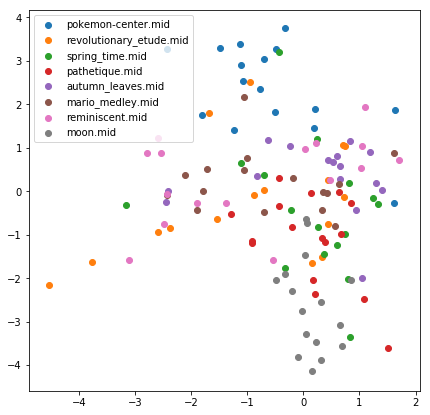

1000 5.321673393249512


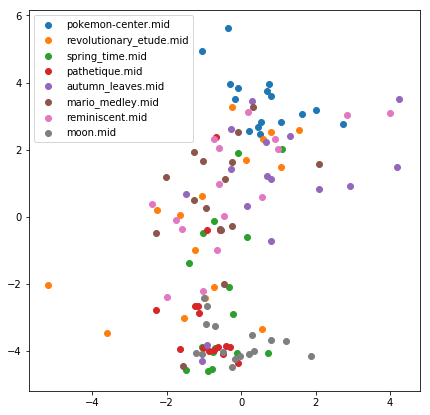

1500 4.942208290100098


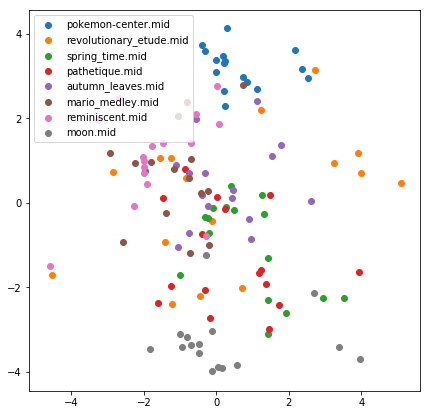

2000 4.762443542480469


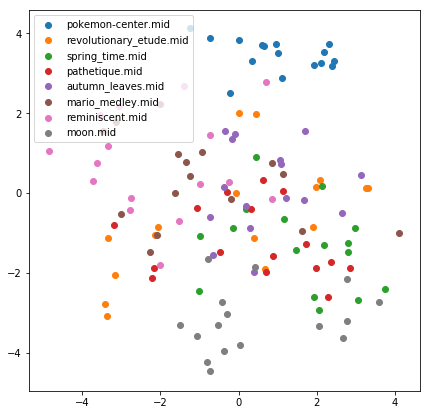

2500 4.360683441162109


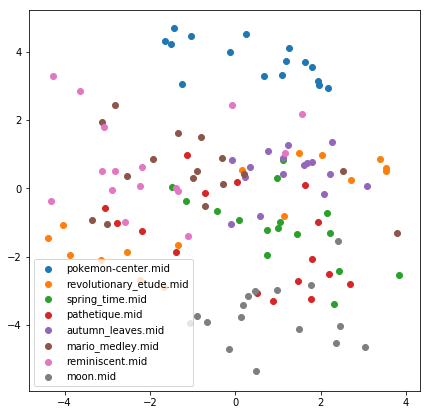

3000 4.50222110748291


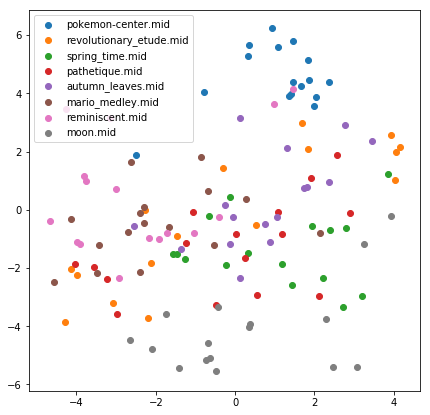

3500 3.846395254135132


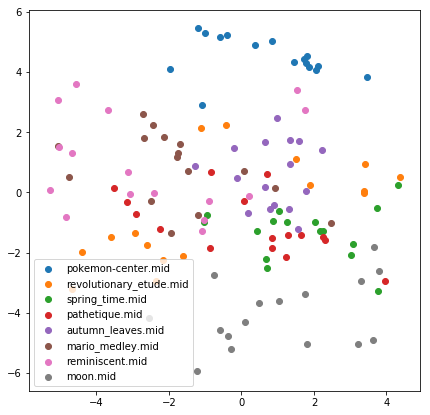

4000 4.081487655639648


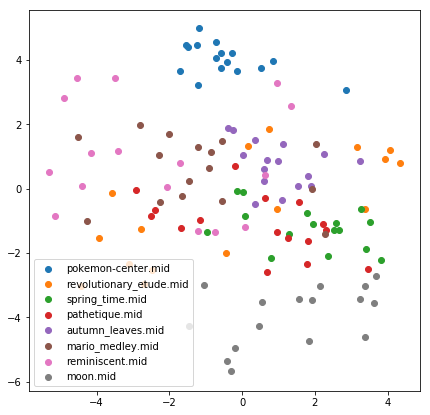

4500 3.474174737930298


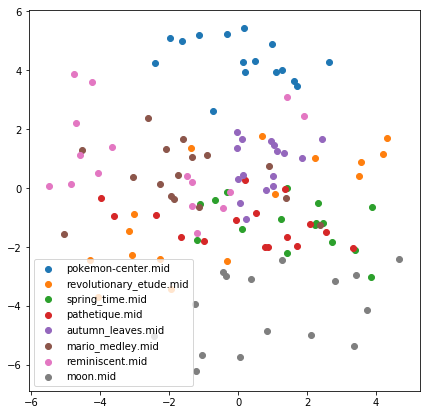

5000 3.2939724922180176


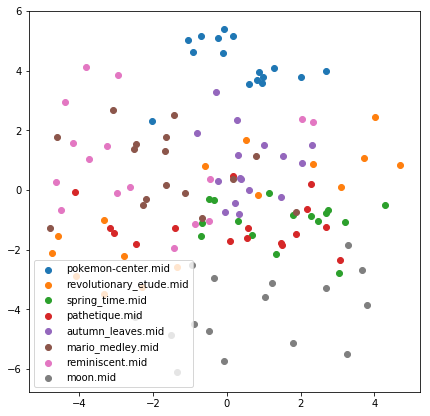

5500 3.304015636444092


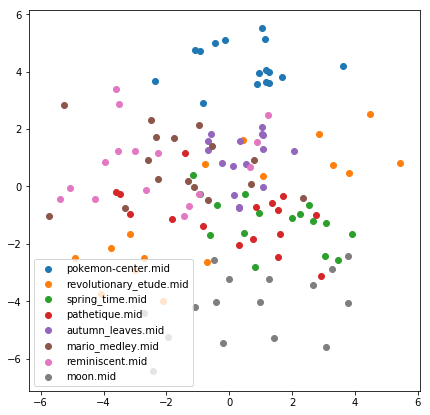

6000 2.8581135272979736


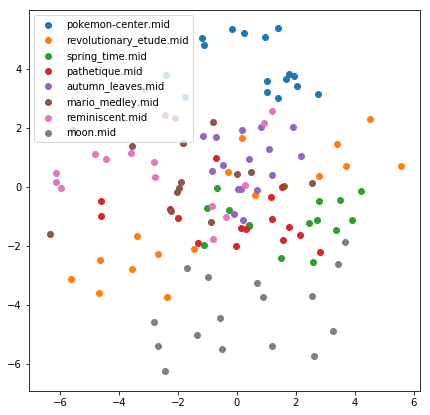

6500 2.639171838760376


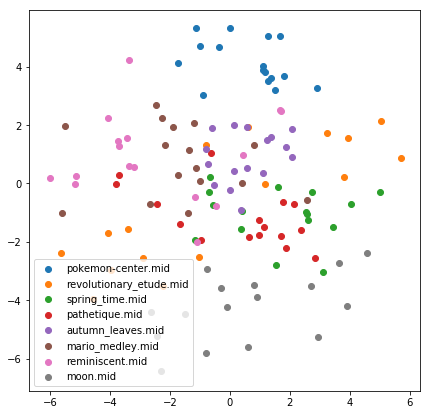

7000 2.225693702697754


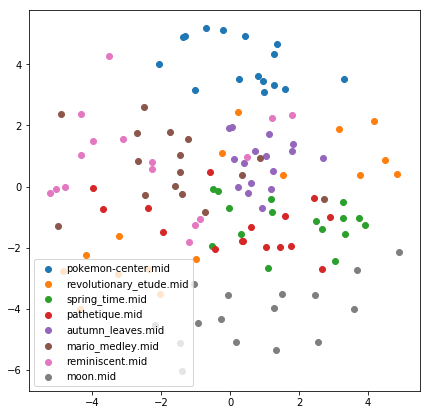

7500 2.4207375049591064


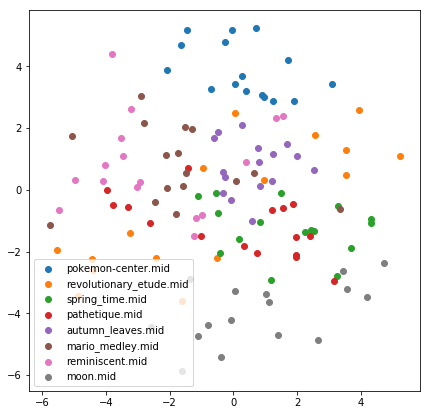

8000 2.091592311859131


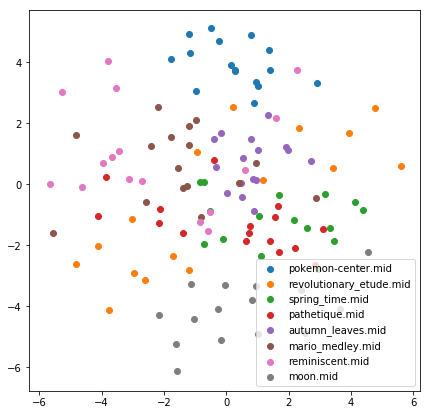

8500 1.7338619232177734


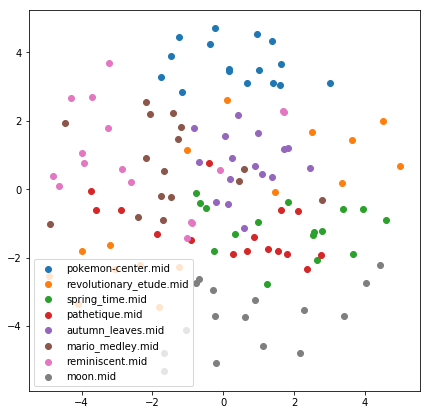

9000 1.8397095203399658


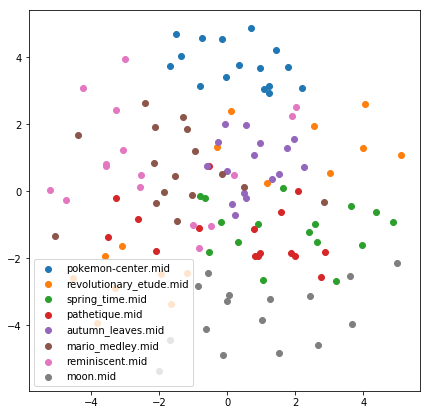

9500 1.6348035335540771


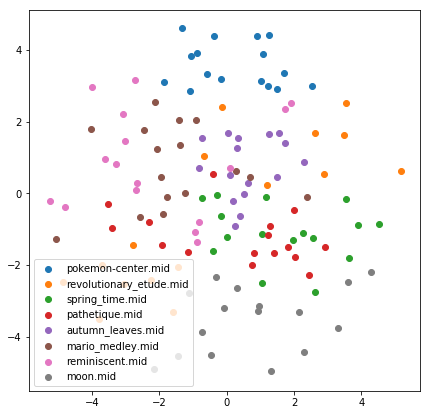

10000 1.3234502077102661


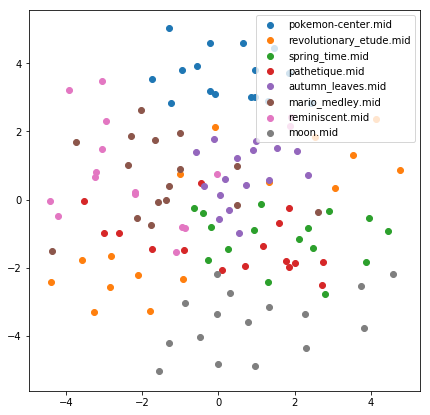

10500 1.5315676927566528


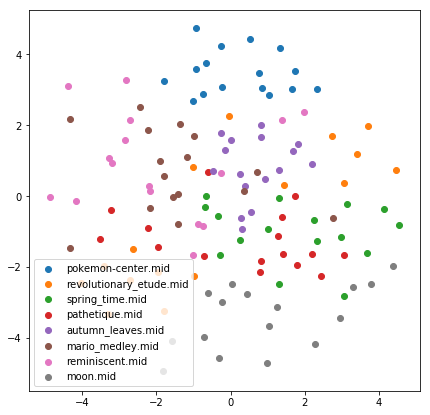

11000 1.2777316570281982


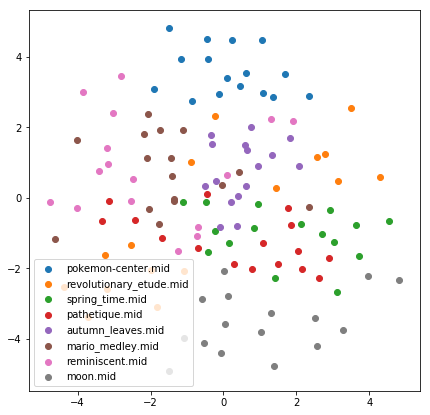

11500 0.9428582787513733


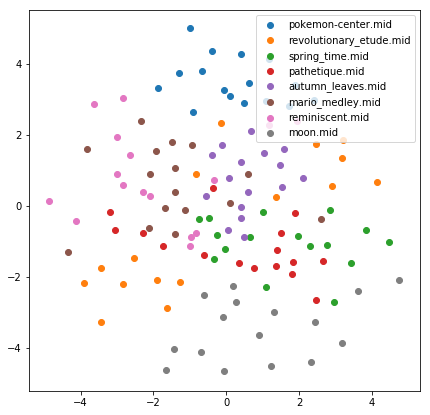

12000 1.0157935619354248


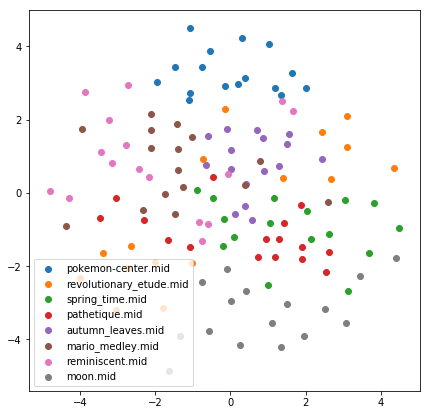

12500 0.8415828943252563


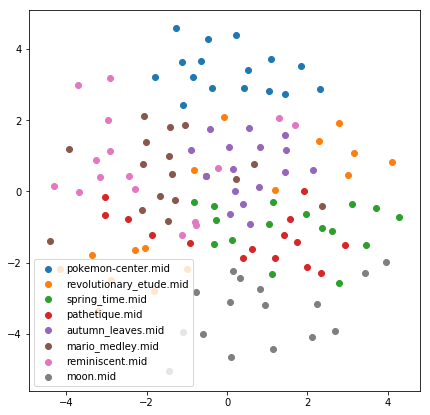

13000 1.653219223022461


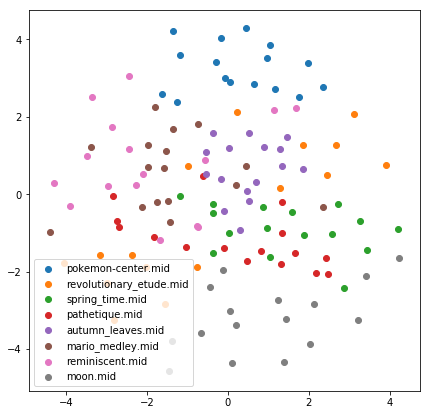

13500 0.6853735446929932


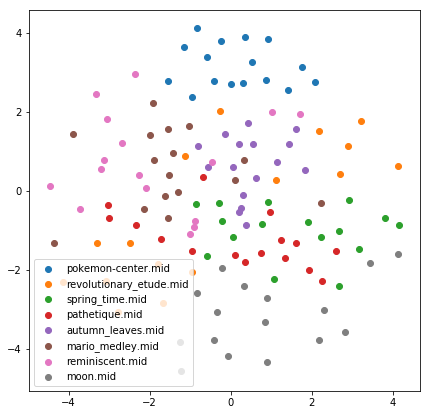

14000 0.5439393520355225


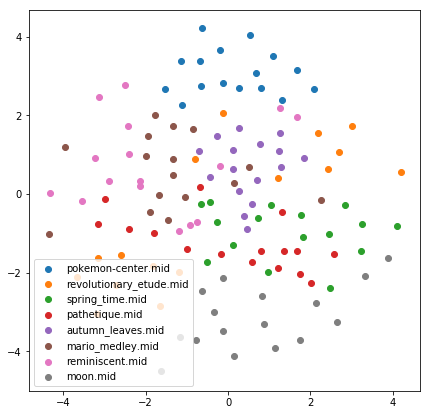

14500 0.6163660883903503


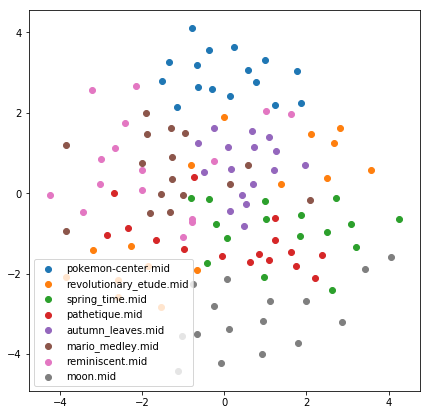

15000 0.3830558955669403


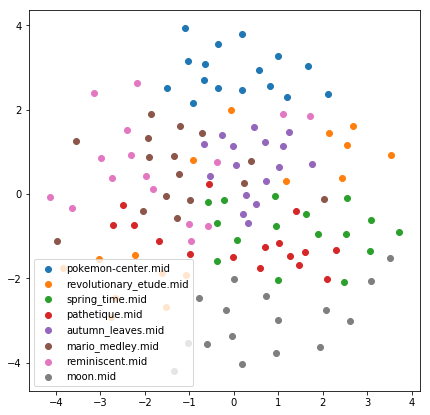

15500 0.4607698321342468


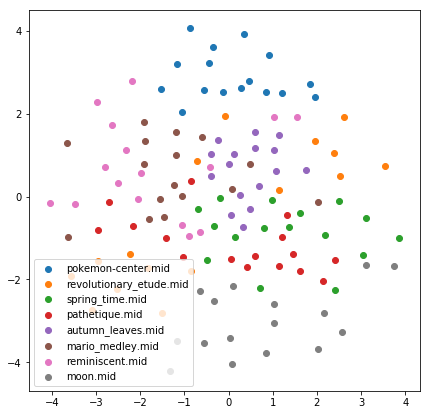

16000 0.30112090706825256


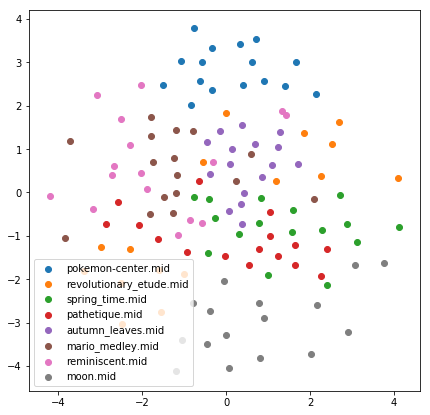

16500 0.42548713088035583


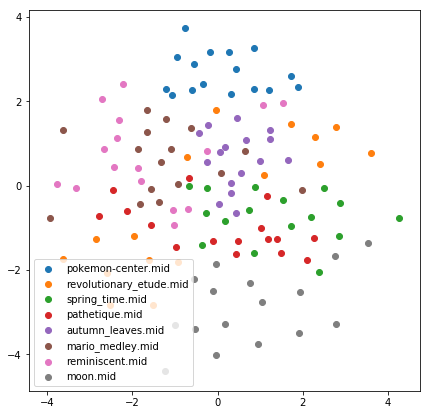

17000 0.3101624548435211


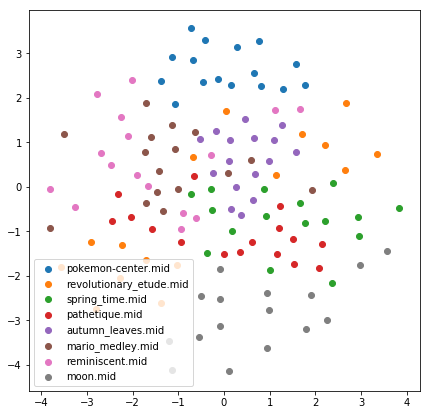

17500 0.3434958755970001


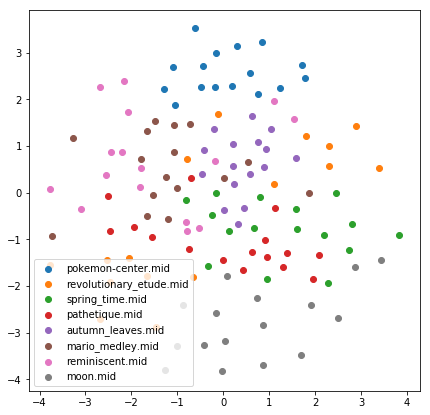

18000 0.43509823083877563


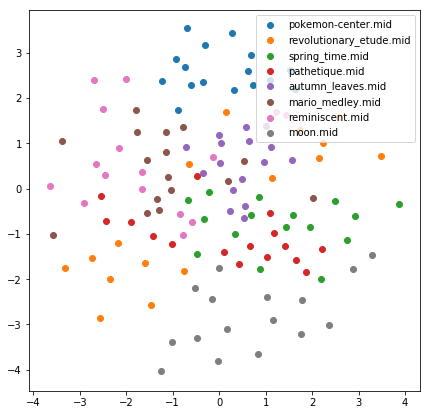

18500 0.4734776020050049


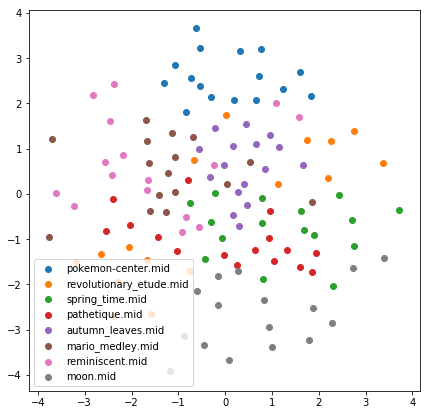

19000 0.5498818755149841


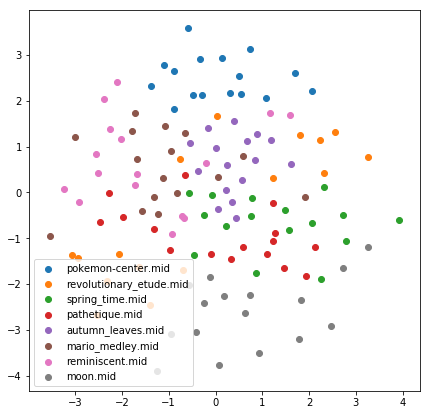

19500 0.5212541222572327


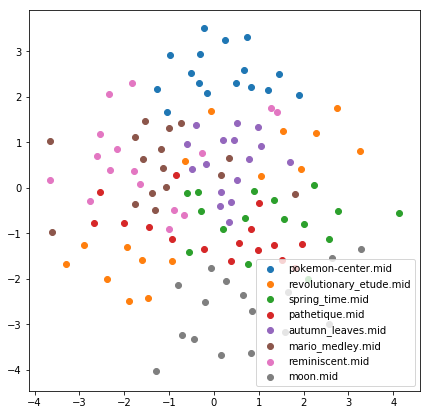

20000 0.18733155727386475


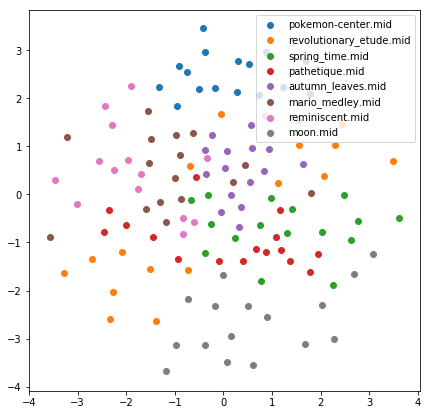

20500 0.7825272083282471


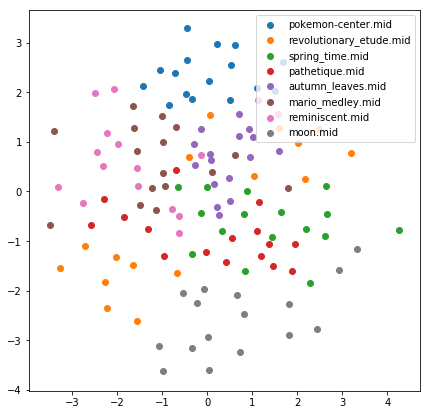

21000 0.4062138795852661


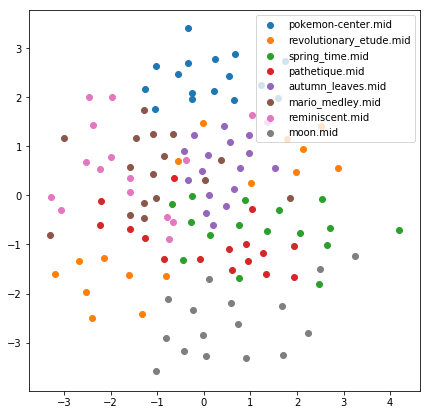

21500 0.3641846477985382


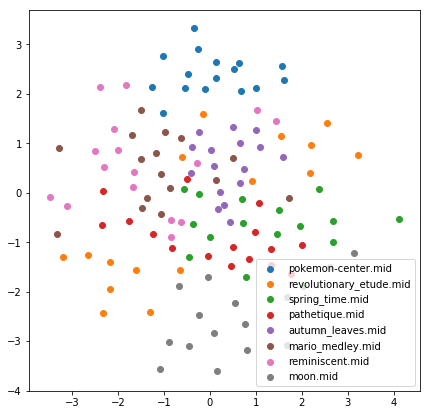

22000 0.42169928550720215


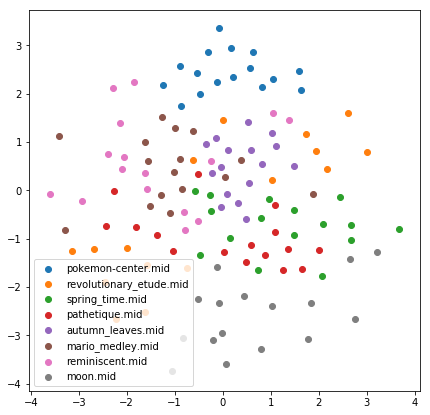

22500 0.35592493414878845


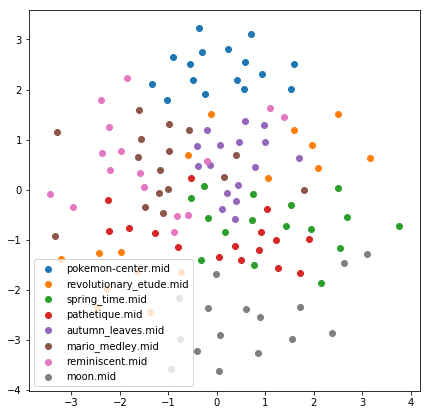

23000 0.2531506419181824


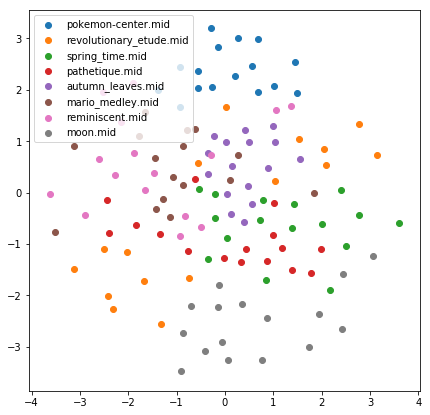

23500 0.18300464749336243


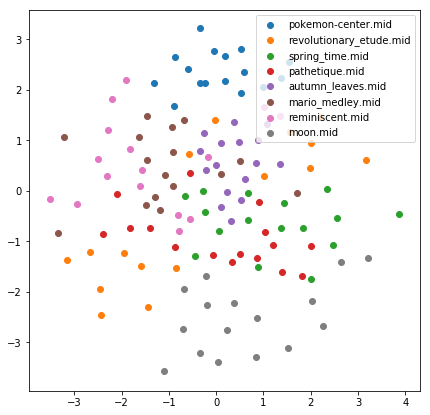

24000 0.27965256571769714


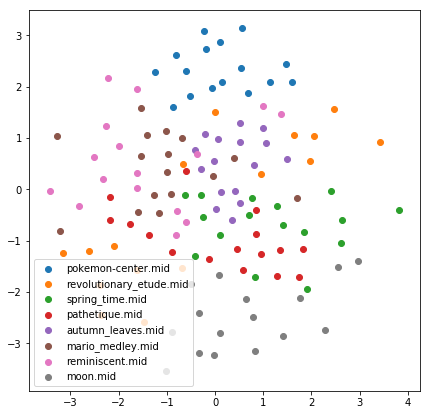

24500 0.2879911959171295


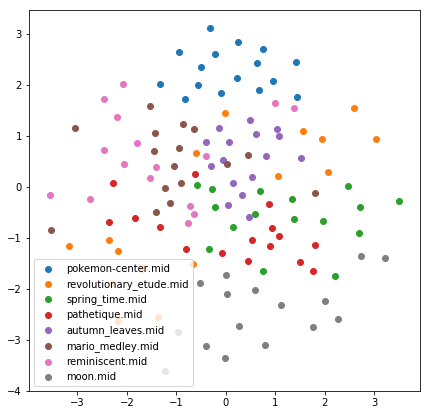

25000 0.42978376150131226


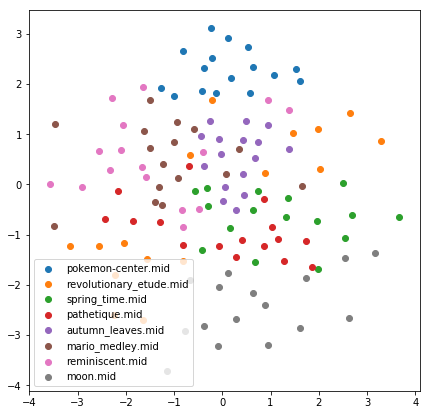

25500 0.25261610746383667


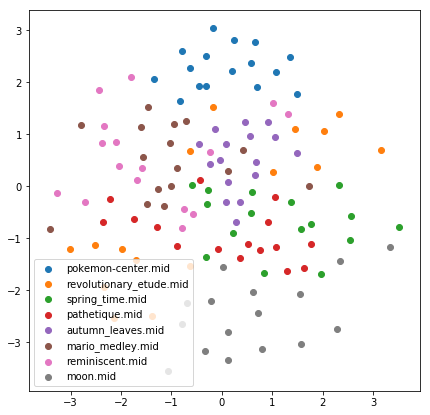

26000 0.20125241577625275


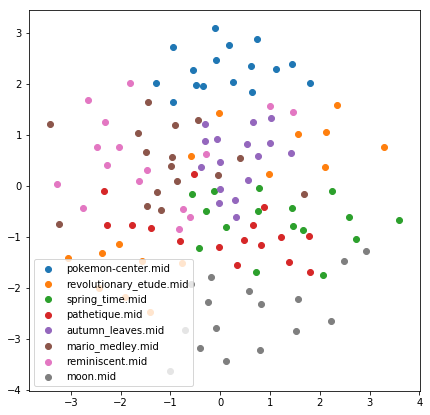

26500 0.5051028728485107


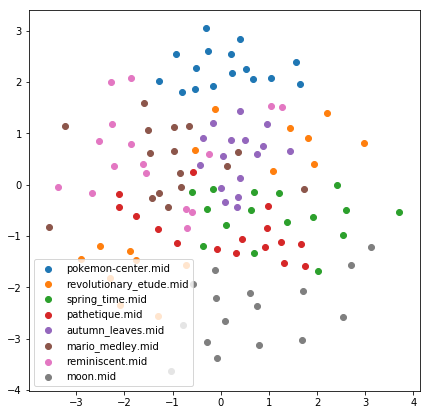

27000 0.3452118933200836


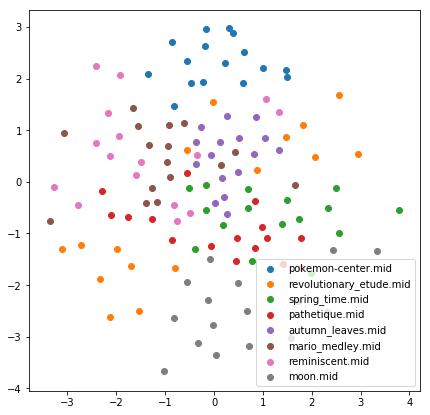

27500 0.15325535833835602


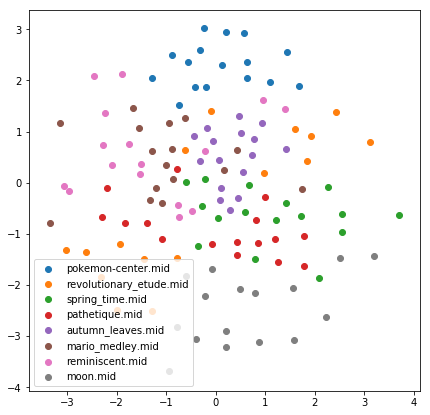

28000 0.17807921767234802


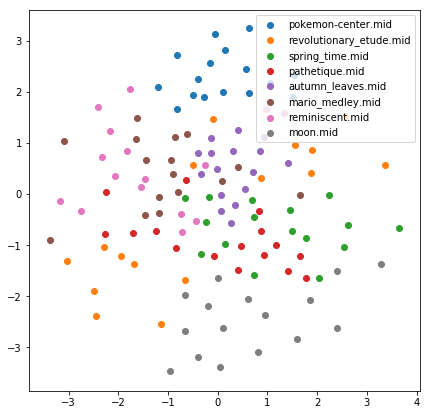

28500 0.15230947732925415


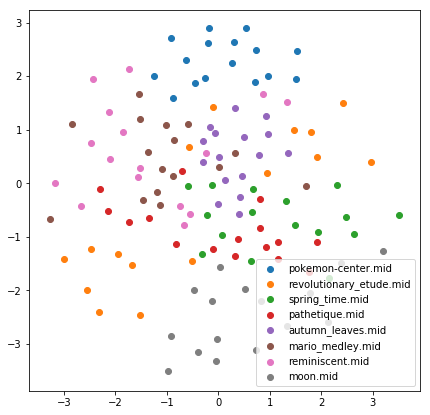

29000 0.18341639637947083


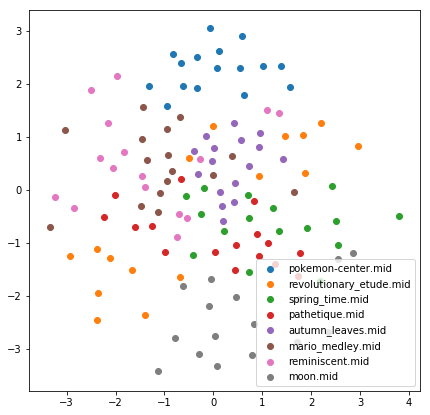

29500 0.3074851334095001


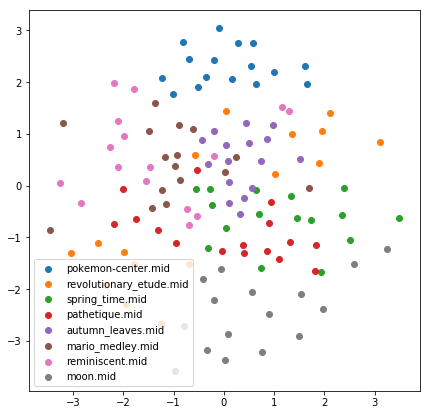

30000 0.30310964584350586


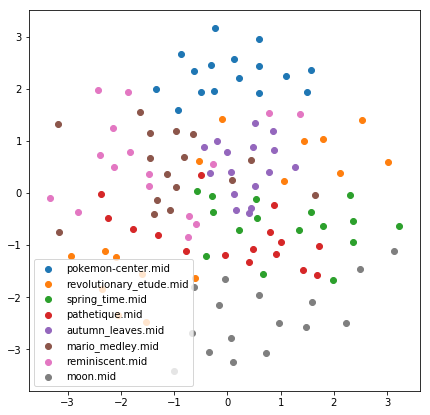

30500 0.21428993344306946


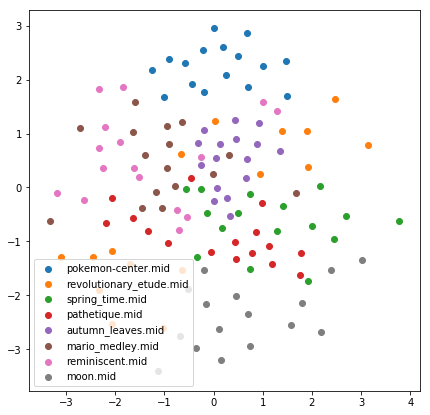

31000 0.29575955867767334


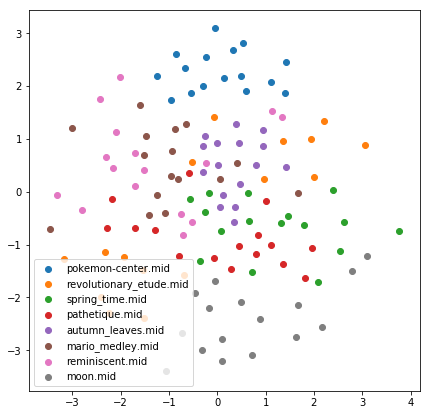

31500 0.30589959025382996


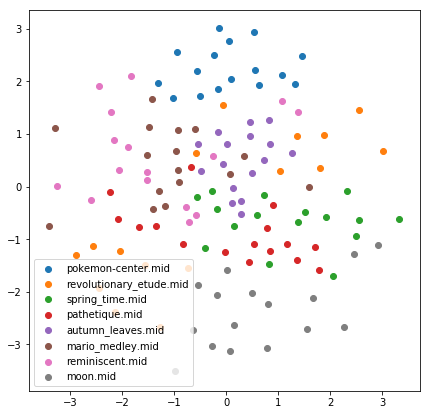

32000 0.35417360067367554


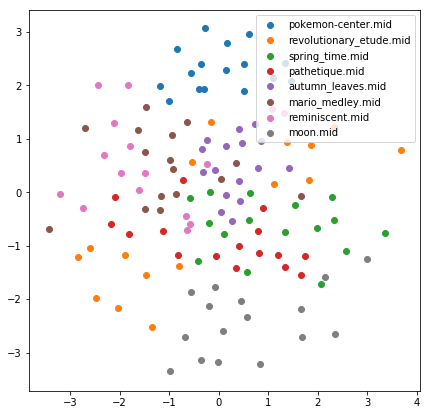

32500 0.4840097427368164


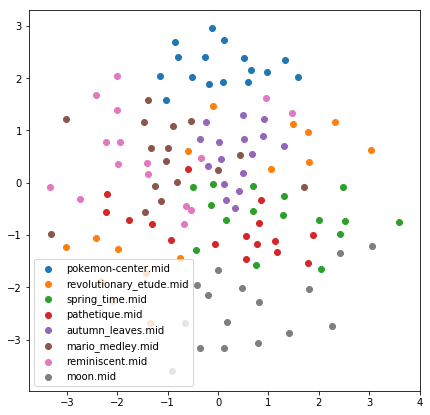

33000 0.14758527278900146


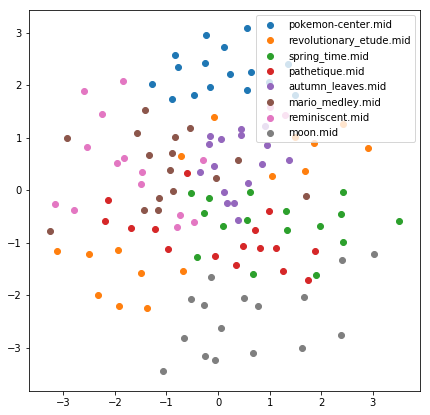

33500 0.29863113164901733


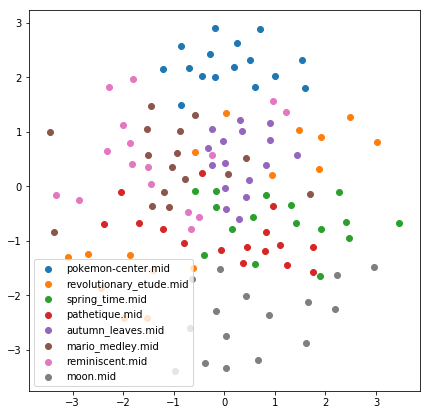

34000 0.14486533403396606


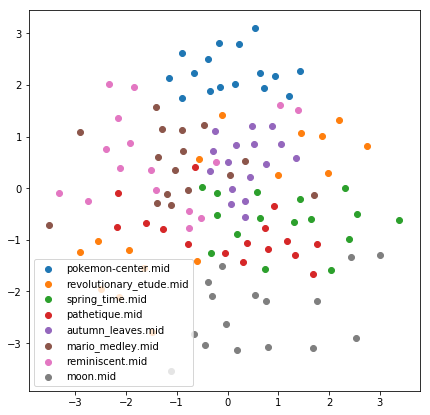

34500 0.32540738582611084


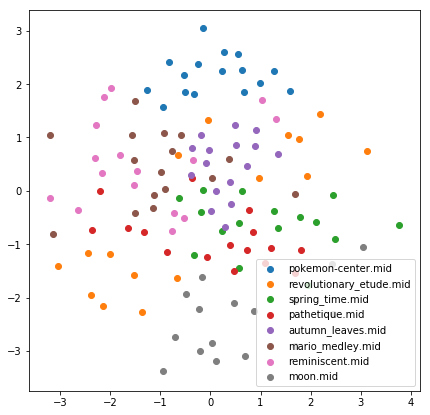

35000 0.3087635934352875


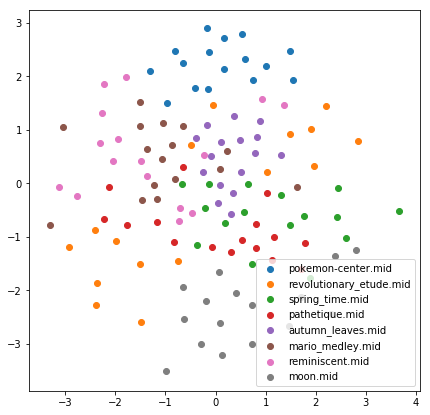

35500 0.3353995084762573


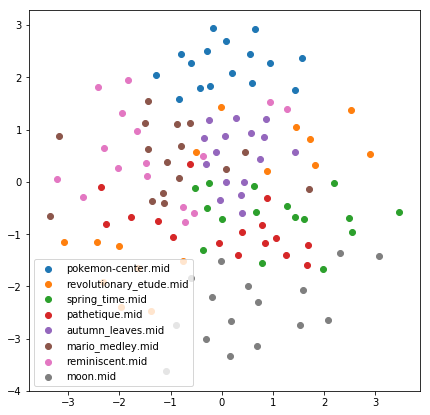

36000 0.1483830362558365


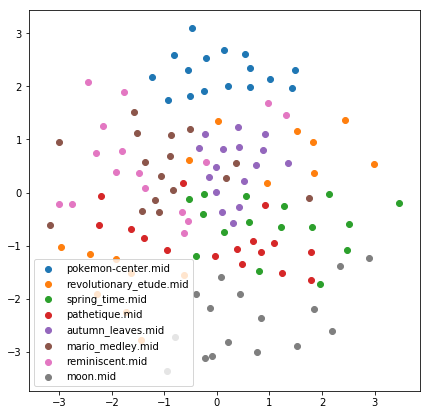

36500 0.14399056136608124


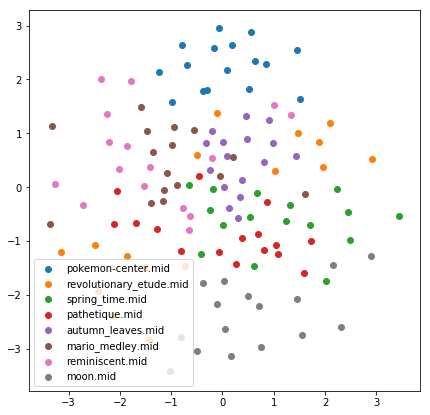

37000 0.1436309665441513


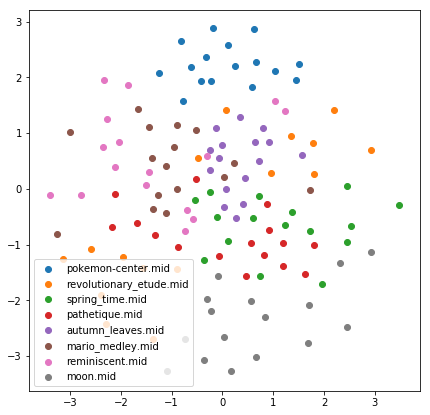

37500 0.2504409849643707


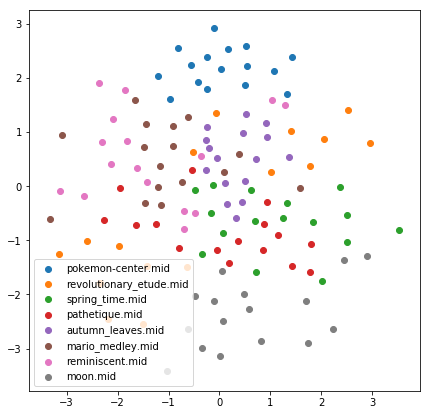

38000 0.40233322978019714


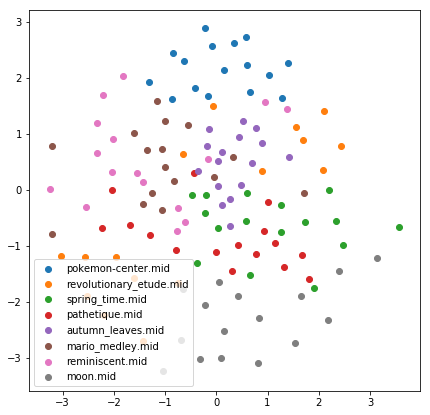

38500 0.27832233905792236


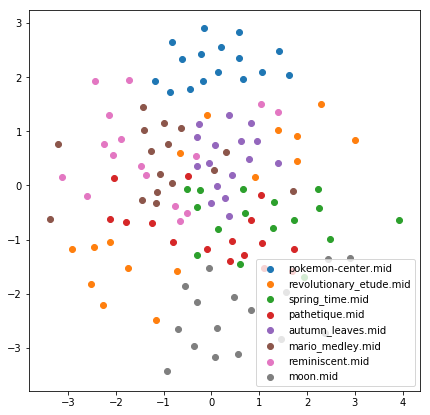

39000 0.27636605501174927


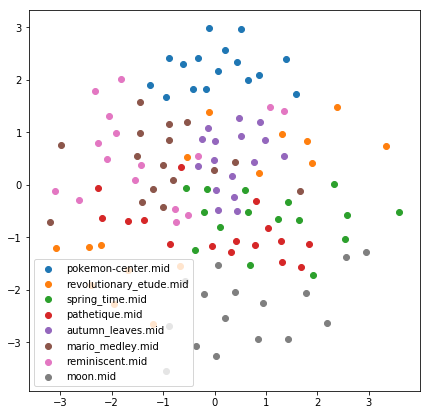

39500 0.17356501519680023


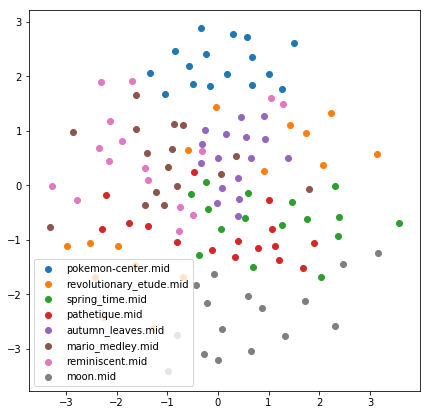

40000 0.3570767343044281


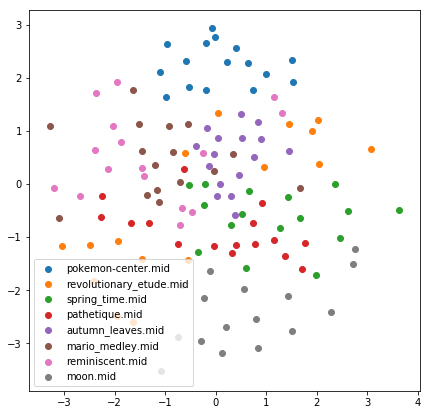

In [6]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter(logdir="experiment_1", graph=sess.graph)
    init.run()
    
    run = [train_op, vrae["total_loss"], vrae["z"], global_step, summ_op]
    for epoch in range(40000):
        try:
            idxs = np.random.permutation(len(X))
            total_loss = []
            Z = []
            Y = []
            for idx in np.array_split(idxs, len(X)//32):
                xb, yb = X[idx], y[idx]
                _, loss, z, step, summ = sess.run(run, feed_dict={inputs: xb})
                writer.add_summary(summ, step)
                total_loss.append(loss)
                Z.append(z)
                Y.append(yb)

            if (epoch+1) % 500 == 0:
                print("{} {}".format(epoch+1, np.mean(total_loss)))

                Z = np.concatenate(Z, axis=0)
                Y = np.concatenate(Y, axis=0)
                fig = plt.figure(figsize=(7, 7))
                ax = fig.add_subplot(1, 1, 1)
                for i in range(8):
                    zz = Z[Y==i]
                    ax.scatter(zz[:, 0], zz[:, 1], label=os.path.split(files[i])[-1])
                plt.legend()
                plt.show()

            if (epoch+1) % 1000 == 0:
                saver.save(sess, "experiment_1/vrae", global_step=step)
                
        except KeyboardInterrupt:
            saver.save(sess, "experiment_1/vrae", global_step=step)
            break

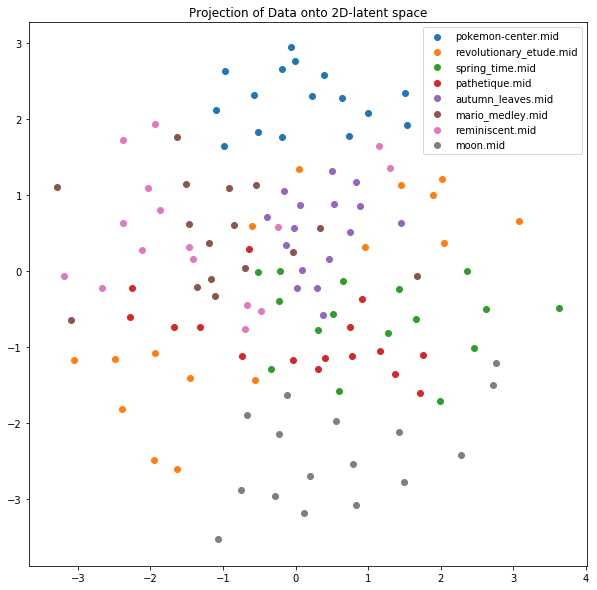

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
for i in range(8):
    zz = Z[Y==i]
    ax.scatter(zz[:, 0], zz[:, 1], label=os.path.split(files[i])[-1])
plt.title("Projection of Data onto 2D-latent space")
plt.legend()
plt.show()

### Reconstruction 
Randomly choose a sequence from dataset and reconstruct

INFO:tensorflow:Restoring parameters from experiment_1/vrae-159999


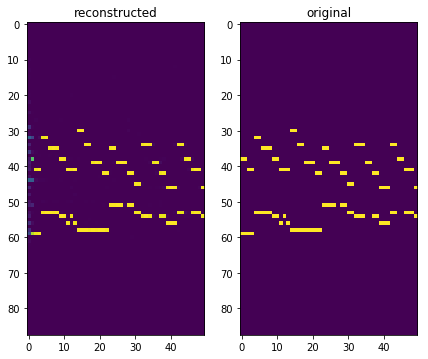

In [9]:
tf.reset_default_graph()
n = 50
inputs = tf.placeholder(tf.float32, (None, 50, 88), name="X")
vrae = model.build_vrae(inputs, rnn_dim=500, z_dim=2)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "experiment_1/vrae-159999")
    outputs = sess.run(vrae["x_out"], feed_dict={inputs: X[n:n+1]})
    test_output = sess.run(vrae["x_out"], feed_dict={inputs: np.expand_dims(test, axis=0)})

output_to_midi(test_output, "experiment_1/reconstruct.mid")

plt.figure(figsize=(7, 10))

plt.subplot(121)
plt.imshow(np.squeeze(outputs, axis=0).T)
plt.title("reconstructed")

plt.subplot(122)
plt.imshow(X[n].T)
plt.title("original")

plt.show()

### Synthesizing new music

In [11]:
tf.reset_default_graph()
time_step = 500
z = tf.placeholder(tf.float32, (None, 2))
_, _, out = model.decoder(z, 500, 88, time_step)
decoder_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="decoder")
saver = tf.train.Saver(decoder_var)
with tf.Session() as sess:
    saver.restore(sess, "experiment_1/vrae-159999")
    outputs = sess.run(out, feed_dict={z: np.random.uniform(size=(5, 2))})

for i in range(len(outputs)):
    temp = outputs[i]
    output_to_midi(np.expand_dims(temp, axis=0), "experiment_1/syntz_{}.mid".format(i))

INFO:tensorflow:Restoring parameters from experiment_1/vrae-159999


## Experiment 2
Changes as compared to first experiment:
1. z dim = 20
1. learning rate = 2e-5, adjusted to 1e-5 after 16000 epochs
1. input is now 40 time steps with overlap

In [12]:
X = []
for roll in piano_rolls:
    for i in range(0, 800, 20):
        temp = roll.T[i:i+40, 21:109]
        X.append(temp)
    
y = []
for i in range(8):
    y.append(np.ones((40,), dtype=np.int32)*i)
    
X = np.stack(X)
y = np.concatenate(y)

test = piano_rolls[0].T[-40:, 21:109]

print(X.shape)
print(y.shape)

(320, 40, 88)
(320,)


In [13]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, (None, 40, 88), name="X")
vrae = model.build_vrae(inputs, rnn_dim=500, z_dim=20)

lr = tf.placeholder(tf.float32)
global_step = tf.train.create_global_step()
opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.05, beta2=0.001)
train_op = opt.minimize(vrae["total_loss"], global_step=global_step)

summaries = [tf.summary.scalar("lower_bound", vrae["latent_loss"]), 
             tf.summary.scalar("reconstruction_loss", vrae["recon_loss"]),
             tf.summary.scalar("loss", vrae["total_loss"]), 
             tf.summary.image("reconstructed", tf.expand_dims(vrae["x_out"]*255, axis=-1))]
summ_op = tf.summary.merge(summaries)

saver = tf.train.Saver(max_to_keep=20)
init = tf.global_variables_initializer()

In [14]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter(logdir="experiment_2", graph=sess.graph)
    init.run()
    
    run = [train_op, vrae["total_loss"], summ_op, global_step]
    for epoch in range(40000):
        try:
            idxs = np.random.permutation(len(X))
            total_loss = []
            for idx in np.array_split(idxs, len(X)//64):
                xb, yb = X[idx], y[idx]
                if (epoch+1) > 16000:
                    learning_rate = 1e-5
                else:
                    learning_rate = 2e-5
                _, loss, summ, step = sess.run(run, feed_dict={inputs: xb, lr: learning_rate})
                writer.add_summary(summ, step)
                total_loss.append(loss)

            if (epoch+1) % 500 == 0:
                print("{} {}".format(epoch+1, np.mean(total_loss)))

            if (epoch+1) % 1000 == 0:
                saver.save(sess, "experiment_2/vrae", global_step=step)
                
        except KeyboardInterrupt:
            saver.save(sess, "experiment_2/vrae", global_step=step)
            break

500 4.551734924316406
1000 4.543832778930664
1500 4.536263942718506
2000 4.0960235595703125
2500 3.9661240577697754
3000 3.976163148880005
3500 3.856027126312256
4000 3.790433883666992
4500 3.7313144207000732
5000 3.6748530864715576
5500 3.6201679706573486
6000 3.56933856010437
6500 3.508883237838745
7000 3.4921698570251465
7500 3.4047019481658936
8000 3.3293919563293457
8500 3.2705178260803223
9000 3.2231574058532715
9500 3.163597345352173
10000 3.125159502029419
10500 3.060539484024048
11000 3.008559226989746
11500 2.9582672119140625
12000 2.8895602226257324
12500 2.832091808319092
13000 2.7908213138580322
13500 2.721588611602783
14000 2.6667680740356445
14500 2.6025829315185547
15000 2.579371452331543
15500 2.5150294303894043
16000 2.4519734382629395
16500 2.398719549179077
17000 2.364126682281494
17500 2.3328697681427
18000 2.3048431873321533
18500 2.2634196281433105
19000 2.2438721656799316
19500 2.212078809738159
20000 2.188100576400757
20500 2.151916027069092
21000 2.12718582153

### Visualizing data in latent space using t-SNE

In [18]:
from sklearn.manifold import TSNE
tf.reset_default_graph()

tsne = TSNE()

inputs = tf.placeholder(tf.float32, (None, 40, 88), name="X")
vrae = model.build_vrae(inputs, rnn_dim=500, z_dim=20)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "experiment_2/vrae-199999")
    z = sess.run(vrae["z"], feed_dict={inputs: X})
    
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

INFO:tensorflow:Restoring parameters from experiment_2/vrae-199999
(320, 2)


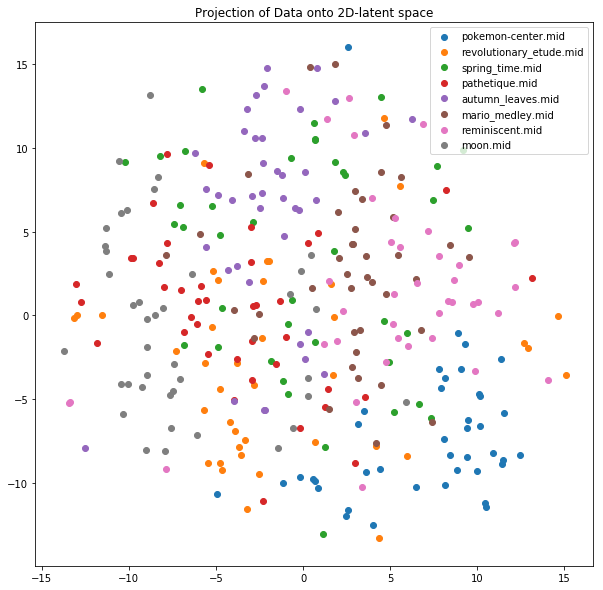

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
for i in range(8):
    zz = z_reduced[y==i]
    ax.scatter(zz[:, 0], zz[:, 1], label=os.path.split(files[i])[-1])
plt.title("Projection of Data onto 2D-latent space")
plt.legend()
plt.show()

### Reconstruction

INFO:tensorflow:Restoring parameters from experiment_2/vrae-199999


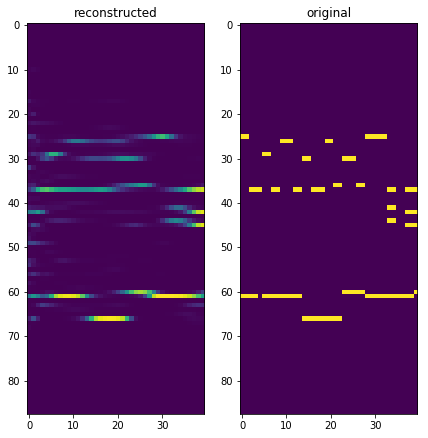

In [21]:
tf.reset_default_graph()
n = 150
inputs = tf.placeholder(tf.float32, (None, 40, 88), name="X")
vrae = model.build_vrae(inputs, rnn_dim=500, z_dim=20)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "experiment_2/vrae-199999")
    outputs = sess.run(vrae["x_out"], feed_dict={inputs: X[n:n+1]})
    test_output = sess.run(vrae["x_out"], feed_dict={inputs: np.expand_dims(test, axis=0)})

output_to_midi(test_output, "experiment_2/reconstruct.mid")

plt.figure(figsize=(7, 10))

plt.subplot(121)
plt.imshow(np.squeeze(outputs, axis=0).T)
plt.title("reconstructed")

plt.subplot(122)
plt.imshow(X[n].T)
plt.title("original")

plt.show()

### Synthesizing new music

In [22]:
tf.reset_default_graph()
time_step = 500
z = tf.placeholder(tf.float32, (None, 20))
_, _, out = model.decoder(z, 500, 88, time_step)
decoder_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="decoder")
saver = tf.train.Saver(decoder_var)
with tf.Session() as sess:
    saver.restore(sess, "experiment_2/vrae-199999")
    outputs = sess.run(out, feed_dict={z: np.random.uniform(size=(5, 20))})

for i in range(len(outputs)):
    temp = outputs[i]
    output_to_midi(np.expand_dims(temp, axis=0), "experiment_2/syntz_{}.mid".format(i))

INFO:tensorflow:Restoring parameters from experiment_2/vrae-199999
